In [1]:
import numpy as np
import os
from os.path import join
from collections import defaultdict
import copy
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# 加载数据
data=np.loadtxt('Data.txt',dtype=int,encoding="utf-8")

### 基础要求

In [3]:
class Graph:
    def __init__(self, nnodes, edges) -> None:
        self.nnodes = nnodes  
        self.in_edge = defaultdict(list)
        self.out_edge=defaultdict(list)
        self.in_degrees_num=[0]*(nnodes+1)# 每个节点有几个入边
        self.out_degrees_num = [0]*(nnodes+1)# 每个节点有几个出边
             
        for i, (fromNodeID, toNodeID) in enumerate(edges):
            self.in_degrees_num[toNodeID]+=1# 入度的数量
            self.out_degrees_num[fromNodeID]+= 1 # 出度的数量
            self.out_edge[fromNodeID].append(toNodeID)# 出度的节点列表
            self.in_edge[toNodeID].append(fromNodeID) # 入度的节点列表

In [4]:
def load_graph() -> Graph:
    
    # 两个整数分别代表边的起始节点和目标节点
    # 获取所有边中出现过的节点，统计节点的个数
    links = []
    unique_nodeindex = set()
    unique_links=set()
    with open('Data.txt', "r", encoding="utf-8") as file:
        for line in file:
            fromNodeID, toNodeID = map(int, line.split())
            links.append((fromNodeID, toNodeID))
            unique_links.add((fromNodeID, toNodeID))
            unique_nodeindex.add(fromNodeID)
            unique_nodeindex.add(toNodeID)
        print("The number of total links: {}".format(len(links)))
        print("The number of unique links: {}".format(len(unique_links))) 
        print ("The number of unique node: {}".format(len(unique_nodeindex)))
       
        # 获取最大的节点ID
        max_node_ID = -1 #最大节点的ID，但不一定等于节点的个数
        for i in links:
            max_node_ID = max(max_node_ID, i[0], i[1])
        print("max node number ID: {}".format(max_node_ID))
    
        # 获取最小的节点ID
        min_node_ID = max_node_ID+1
        for i in links:
            min_node_ID = min(min_node_ID, i[0], i[1])
        print ("min node number ID: {}".format(min_node_ID))
        
        return Graph(max_node_ID, links)

In [5]:
graph=load_graph()

# print(graph)

The number of total links: 135737
The number of unique links: 135737
The number of unique node: 8297
max node number ID: 8297
min node number ID: 1


其实到这里已经可以看出，这个图中并没有既没有入也没有出的节点，数据集中也没有重复出现的边，下面看一下有没有只有入或者只有出的节点

In [6]:
def count_node(graph: Graph)->int:
    no_in_no_out_node_num=0
    only_in_node_num=0
    only_out_node_num=0
    
    for node in range(1 ,graph.nnodes+1):
        if(graph.out_degrees_num[node]==0 and graph.in_degrees_num[node]!=0):
            only_in_node_num+=1
            
        if(graph.out_degrees_num[node]!=0 and graph.in_degrees_num[node]==0):
            only_in_node_num+=1
        
        if (graph.out_degrees_num[node]==0 and graph.in_degrees_num[node]==0):
            isolated_nodes_num+=1
    
    print("Only_in_node_count number: {}".format(only_in_node_num))
    print("Only_out_node_count number: {}".format(only_out_node_num))
        
    return no_in_no_out_node_num

In [7]:
no_in_no_out_node_N=count_node(graph)
print ("No_in_no_out_node number: {}".format(no_in_no_out_node_N))

N = graph.nnodes - no_in_no_out_node_N
print ("Not Isolated node number: {}".format(N))

Only_in_node_count number: 2187
Only_out_node_count number: 0
No_in_no_out_node number: 0
Not Isolated node number: 8297


可以看到，有2187个节点只有入度，没有出度；在数据集中没有只有出度没有入度的节点。这些只有入度没有出度的节点需要考虑dead ends问题，因为它不会将 PageRank 分数传递给其他节点，也不会从其他节点接收 PageRank 分数。

In [8]:
# 构造稀疏矩阵
def sparse_matrix(graph: Graph) -> np.ndarray:
    n = graph.nnodes
    sparse_matrix = np.zeros((n, n))
    
    for src in range(1, n + 1):
        if graph.out_degrees_num[src] == 0:
            continue
        for dst in graph.in_edge[src]:
            sparse_matrix[dst - 1, src - 1] = 1 / graph.out_degrees_num[src]
            
    return sparse_matrix

In [9]:
sparse_matrix = sparse_matrix(graph)
# print(sparse_matrix)

发现这个稀疏矩阵里有好多0，浪费空间，基础要求中不直接使用稀疏矩阵参与运算

In [10]:
BETA = 0.85
MIN_DELTA = 1.27e-5
MAX_ITER = 100

In [11]:
# ppt第54页
def pagerank(graph: Graph, N):
    
    # 初始化PageRank值为1/N
    initial_pr = np.full(graph.nnodes+1, np.float64(1 / N))
    
    # 把只有入度或只有出度的点的初始pagerank值设为0
    for node in range(1,graph.nnodes+1):
        if(graph.out_degrees_num[node]==0 or graph.in_degrees_num[node]==0):
            initial_pr[node]=0
    
    pr_old=copy.deepcopy(initial_pr)
    iter_count=0
    
    while iter_count < MAX_ITER:     
        iter_count +=1
        
        # pr_new初始化存储新的PageRank值
        pr_new = np.zeros(graph.nnodes + 1)
        
        # 当一个节点没有出度时，它会被称为一个dead ends，因为它不会将 PageRank 分数传递给其他节点，也不会从其他节点接收 PageRank 分数。
        # 使用Teleport解决Dead ends问题，通过随机跳转重新分配给所有节点
        # 将节点图转化成列转移概率矩阵，再修正马尔科夫矩阵  
        
        for node in range(1, graph.nnodes+ 1):
            if graph.in_degrees_num[node]==0:
                pr_new[node]=0
            else:
                for src in graph.in_edge[node]:
                    pr_new[node] += BETA*(pr_old[src] / graph.out_degrees_num[src])
        pr_sum=np.sum(pr_new)   
        
        # 处理Spider Traps
        # 某节点与其他节点之间不存在出链，即存在自环，可能导致网站权重向某一个含自环的节点偏移
        # 使用 Random Telport解决Spider Traps问题，将节点图转化成转移概率矩阵，再修正马尔科夫矩阵
        pr_new+=(1-pr_sum)/ N 
        
        # 将孤立结点的PageRank值设置为0，但这个数据集其实可以不考虑的
        # for node in range(1 ,graph.nnodes+1):
            # if (graph.out_degrees_num[node]==0 and graph.in_degrees_num[node]==0):
               # pr_new[node]=0
                
        pr_sum = np.sum(pr_new)

        error = 0.
        for i in range(graph.nnodes + 1):
            if(error < abs(pr_new[i] - pr_old[i])):
                error= abs(pr_new[i] - pr_old[i])  
            
        print(iter_count, error)
        
        if (error < MIN_DELTA):
            break
            
        pr_old = copy.deepcopy(pr_new)

    result = {}
    for i in range(1, graph.nnodes+1):
        result[i] = pr_new[i]
        
    return result

In [12]:
result=pagerank(graph,N)
result=sorted(result.items(),key=lambda x:x[1],reverse=True)

1 0.00018190884652544495
2 0.00011932359641105461
3 9.590864521702956e-05
4 7.66679528053034e-05
5 6.12164309055002e-05
6 4.888363384863894e-05
7 3.903485570227062e-05
8 3.11704354476589e-05
9 2.4890461674498938e-05
10 1.987573108378133e-05
11 1.587132769776821e-05
12 1.2673699673354673e-05


In [13]:
result=result[:100]

In [14]:
with open(join(join(".","Page_Rank_Results"),"basic.txt"),'w',encoding='utf-8') as f:
    for line in result:
        f.write(f"{line[0]} {line[1]}\n")

### 下面是使用了networkx库得到的结果

In [15]:
# 加载数据
data=np.loadtxt('Data.txt',dtype=int,encoding="utf-8")

In [16]:
# 创建有向图
G=nx.DiGraph()

# 添加边到有向图
for edge in data:
    G.add_edge(edge[0],edge[1])

In [17]:
# 使用Kamada-Kawai布局算法布局节点
# pos_kamada_kawai = nx.kamada_kawai_layout(G)

In [18]:
# 绘制有向图（Kamada-Kawai布局）
# plt.figure(figsize=(50, 50))
# nx.draw(G, pos_kamada_kawai, with_labels=False, node_size=5, node_color='skyblue', edge_color='gray', arrows=True)
# plt.title("Directed Graph Visualization (Kamada-Kawai Layout)")
# plt.show()

In [19]:
# 数据集的大小
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"数据集节点数：{num_nodes}")
print(f"数据集边数：{num_edges}")


数据集节点数：8297
数据集边数：135737


In [20]:
# 统计节点的入度和出度
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())


In [21]:
# 指定字体为宋体
plt.rcParams['font.sans-serif'] = ['SimSun']

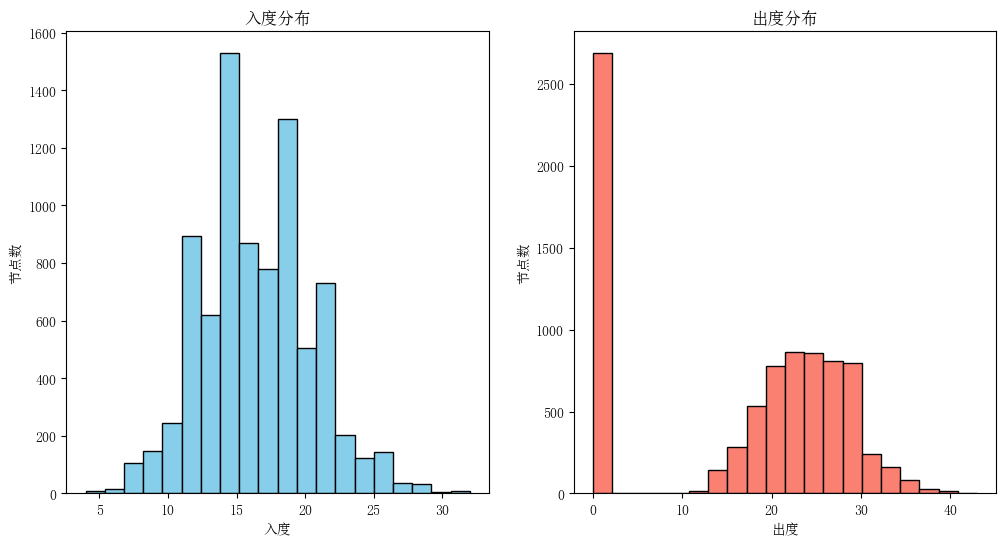

In [22]:
# 绘制节点的入度和出度分布图
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(list(in_degrees.values()), bins=20, color='skyblue', edgecolor='black')
plt.title("入度分布")
plt.xlabel("入度")
plt.ylabel("节点数")
plt.subplot(1, 2, 2)
plt.hist(list(out_degrees.values()), bins=20, color='salmon', edgecolor='black')
plt.title("出度分布")
plt.xlabel("出度")
plt.ylabel("节点数")
plt.show()

可以看到有超过2500个的节点是只有入度没有出度的，会有dead ends的问题

In [23]:
# plt.figure(figsize=(10, 8))
# pos = nx.spring_layout(G)  # 设置节点布局
# nx.draw(G, pos, with_labels=True, node_size=100, node_color='skyblue', edge_color='gray', linewidths=0.5)
# plt.title('Network Visualization')
# plt.show()

In [24]:
# 计算并展示节点的度中心性
# 节点的度中心性是指该节点连接的边的数量与可能的最大连接数之比
# 节点的度中心性越高，意味着该节点在网络中具有更多的连接，可能在信息传播、影响传播等方面发挥更重要的作用

degree_centrality = nx.degree_centrality(G)
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
top_nodes = sorted_degree_centrality[:10]  # 取前10个度中心性最高的节点
print("Top 10 nodes by degree centrality:")
for node, centrality in top_nodes:
    print(f"Node: {node}, Degree Centrality: {centrality}")

Top 10 nodes by degree centrality:
Node: 853, Degree Centrality: 0.007594021215043395
Node: 8078, Degree Centrality: 0.007594021215043395
Node: 3396, Degree Centrality: 0.007594021215043395
Node: 2879, Degree Centrality: 0.007473481195756992
Node: 2006, Degree Centrality: 0.007232401157184185
Node: 7977, Degree Centrality: 0.007232401157184185
Node: 3742, Degree Centrality: 0.007232401157184185
Node: 2061, Degree Centrality: 0.007232401157184185
Node: 4358, Degree Centrality: 0.007232401157184185
Node: 4682, Degree Centrality: 0.007232401157184185


In [25]:
# 社区检测
# 社区指的是网络中节点的子集，这些节点之间存在着更加密集的连接，而与其他节点的连接相对较少。
# 社区检测的目标是将网络中的节点划分为若干个社区，使得社区内部的连接密度较高，而社区之间的连接密度较低。

# communities = nx.algorithms.community.greedy_modularity_communities(G)
# print("\nCommunities:")
# for i, community in enumerate(communities, start=1):
    # print(f"Community {i}: {list(community)}")

In [26]:
# 连通分量分析
connected_components = list(nx.weakly_connected_components(G))
print("\nNumber of Weakly Connected Components:", len(connected_components))
largest_connected_component = max(connected_components, key=len)
print("Size of Largest Weakly Connected Component:", len(largest_connected_component))


Number of Weakly Connected Components: 1
Size of Largest Weakly Connected Component: 8297


In [27]:
# 计算有向图的pagerank值
'''
    G : graph
      A NetworkX graph.  Undirected graphs will be converted to a directed
      graph with two directed edges for each undirected edge.

    alpha : float, optional
      Damping parameter for PageRank, default=0.85.
      
    max_iter : integer, optional
      Maximum number of iterations in power method eigenvalue solver.

    tol : float, optional
      Error tolerance used to check convergence in power method solver.

'''
nx_pagerank=nx.pagerank(G,alpha=0.85,max_iter=100,tol=1e-6)

In [28]:
nx.pagerank

<function networkx.algorithms.link_analysis.pagerank_alg.pagerank(G, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None)>

可以看到networkx的默认参数为max_iter=100,tol=1e-6,alpha=0.85

In [29]:
nx_result=sorted(nx_pagerank.items(),key=lambda x: x[1],reverse=True)

In [30]:
# 提取前100个元素
nx_result = nx_result[:100]

In [31]:
# 将前100个结果写进结果文件nx_result.txt
with open(join(join(".","Page_Rank_Results"),"nx_result.txt"), 'w', encoding='utf-8') as f:
    for line in nx_result:
        f.write(f"{line[0]} {line[1]}\n")

通过对比可以看出，我们前面自行实现的pagerank运行的结果与和调库实现基本一致，但在小数点后17位出现不一致

下面对不同的alpha进行分析

In [32]:
# 尝试不同的 alpha 值并评估
# alpha_values = [0.1, 0.25, 0.5, 0.75, 0.85, 0.9, 0.95]
# stability_scores = []
# best_alpha = None
# best_score = -float('inf')

In [33]:
# 计算节点 PageRank 值在不同迭代次数下的变化
# max_iterations = 100
# iterations = list(range(1, max_iterations + 1))

In [34]:
# for alpha in alpha_values:
    # pagerank_stabilities = []
    # for iter_num in iterations:
        # try:
            # 计算 PageRank
            # nx_pagerank = nx.pagerank(G, alpha=alpha, max_iter=iter_num, tol=1e-6)
            # pagerank_values = list(nx_pagerank.values())
            # 计算节点 PageRank 值的标准差，作为稳定性评价指标
            # pagerank_stability = np.std(pagerank_values)
            # pagerank_stabilities.append(pagerank_stability)
        # except nx.PowerIterationFailedConvergence:
            # 如果收敛失败，则记录为 NaN
            # pagerank_stabilities.append(np.nan)
    # stability_scores.append(pagerank_stabilities)

In [35]:
# 绘制稳定性评价指标随迭代次数的变化曲线
# plt.figure(figsize=(10, 6))
# for i, alpha in enumerate(alpha_values):
   #  plt.plot(iterations, stability_scores[i], label=f"Alpha={alpha}")

In [36]:
# plt.xlabel('Iterations')
# plt.ylabel('PageRank Stability (Std)')
# plt.legend()
# plt.title('PageRank Stability with different alpha values')
# plt.grid(True)
# plt.show()

# 选出最佳的 alpha 值（稳定性最好）
# best_alpha_index = np.argmin([max(stability) for stability in stability_scores])
# best_alpha = alpha_values[best_alpha_index]
# print(f"Best alpha value: {best_alpha}")

In [37]:
# for alpha in alpha_values:
    # 计算 PageRank
    # nx_pagerank = nx.pagerank(G, alpha=alpha, max_iter=100, tol=1e-6)
    # pageranks[alpha] = nx_pagerank

In [38]:
# 绘制 PageRank 值随 alpha 变化的曲线
# for node in G.nodes():
    # plt.plot(alpha_values, [pageranks[alpha][node] for alpha in alpha_values], label=f"Node {node}")

# plt.xlabel('Alpha')
# plt.ylabel('PageRank')
# plt.legend()
# plt.title('PageRank with different alpha values')
# plt.show()

### 矩阵分块优化

In [39]:
block_size=2000# 分块，每个块中有2000组数据

In [40]:
links=[]

with open('Data.txt', "r", encoding="utf-8") as file:
        for line in file:
            fromNodeID, toNodeID = map(int, line.split())
            links.append((fromNodeID, toNodeID))

In [41]:
sorted_data=sorted(links,key=lambda x:x[1],reverse=False)

In [42]:
with open(join(join(".","Page_Rank_Results"),"new_sorted_data.txt"),'w',encoding='utf-8') as f:
    for line in sorted_data:
        f.write(f"{line[0]} {line[1]}\n")

In [43]:
# 对数据进行分块并储存在指定路径(./Page_Rank_Results/Block_Split_Data文件夹里的以数字序号命名的.txt文件)
def datablock_split(splitLen):
    data =open('new_sorted_data.txt', "r", encoding="utf-8")
    count=0
    end=None
    at=0
    
    for line in data:
        if count % splitLen == 0:
            if end: 
                end.close()
            end = open('./Page_Rank_Results/Block_Split_Data/' + str(at) + '.txt', 'w')
            at += 1
        end.write(line)
        count += 1

    return at

In [44]:
data_split_num = datablock_split(block_size)

print("Data_split_num is : {}".format(data_split_num))

Data_split_num is : 68


In [45]:
class Block_Graph:
    def __init__(self, nnodes, edges) -> None:
        self.nnodes=nnodes  
        self.in_edges=defaultdict(list)
        self.out_degrees=defaultdict(list)
        self.in_degrees_num=[0]*(nnodes+1)# 每个节点有几个入边
        self.out_degrees_num = [0]*(nnodes+1)# 每个节点有几个出边
             
        for i, (src, dst) in enumerate(edges):
            self.in_degrees_num[dst]+=1# 入度的数量
            self.out_degrees_num[src]+= 1 # 出度的数量
            self.out_degrees[src].append(dst)# 出度的节点列表
            self.in_edges[dst].append(src) # 入度的节点列表

In [46]:
# 这个函数其实是把所有分块后的数据文件都读了的，构建的图结构与基础要求构建理论上其实是一致的
def block_load_graph(path,data_split_num) -> Block_Graph:
    
    # 矩阵每行代表图的一条边，两个整数分别代表边的起始节点和目标节点
    # 获取所有边中出现过的节点，统计节点的个数
    links = []
    unique_nodeindex = set()
    index = []
    unique_links=set()
    
    for i in range (data_split_num):
        block_path=path+str(i)+'.txt'
        f=open(block_path,'r')
        for line in f:
            x, y = map(int, line.split())
            links.append((x, y))
            unique_links.add((x, y))
            unique_nodeindex.add(x)
            unique_nodeindex.add(y)
            index.append(int(x))
            index.append(int(y))
    # print("number of total links: {}".format(len(links)))
    # print("number of unique links: {}".format(len(unique_links))) 
    # print ("total node number : {}".format(len(unique_nodeindex)))
       
    # 获取最大的节点ID
    max_node = -1 #最大节点的ID，但不一定等于节点的个数
    for i in links:
        max_node = max(max_node, i[0], i[1])
    # print("max node number ID: {}".format(max_node))
    
    # 获取最小的节点ID
    min_node = max_node+1
    for i in links:
        min_node = min(min_node, i[0], i[1])
    # print ("min node number ID: {}".format(min_node))
    index = list(np.unique(index))   
    
    return Block_Graph(max_node, links),index

In [47]:
block_graph,index=block_load_graph('./Page_Rank_Results/Block_Split_Data/',data_split_num)

In [48]:
# 这个数据文件只负责读分块后的每个数据文件，与block_load_graph其实是不一致的
def block_split_load_graph(block_path):
    
    # 矩阵每行代表图的一条边，两个整数分别代表边的起始节点和目标节点
    # 获取所有边中出现过的节点，统计节点的个数
    links = []
    unique_nodeindex = set()
    index=[]
    unique_links=set()
    
    f=open(block_path,'r')
    for line in f:
        x, y = map(int, line.split())
        links.append((x, y))
        unique_links.add((x, y))
        unique_nodeindex.add(x)
        unique_nodeindex.add(y)
        index.append(int(x))
        index.append(int(y))
    # print("number of total links: {}".format(len(links)))
    # print("number of unique links: {}".format(len(unique_links))) 
    # print ("total node number : {}".format(len(unique_nodeindex)))
       
    # 获取最大的节点ID
    max_node = -1 #最大节点的ID，但不一定等于节点的个数
    for i in links:
        max_node = max(max_node, i[0], i[1])
    # print("max node number ID: {}".format(max_node))
    
    # 获取最小的节点ID
    min_node = max_node+1
    for i in links:
        min_node = min(min_node, i[0], i[1])
    # print ("min node number ID: {}".format(min_node))
    
    index = list(np.unique(index))  
    
    return Block_Graph(max_node, links),links,index

In [49]:
# block_graph.in_degrees_num

In [50]:
# ppt第54页
def block_pagerank(block_graph: Block_Graph,N,data_split_num):
    
    # Initializing matrix
    # 初始化PageRank值为1/N
    initial_pr = np.full(block_graph.nnodes+1, np.float64(1 / N))
    
    # 把只有入度或者只有出度的点的初始pagerank值设为0
    for node in range(1,block_graph.nnodes+1):
        if(block_graph.out_degrees_num[node]==0 or block_graph.in_degrees_num[node]==0):
            initial_pr[node]=0
    
    pr_old=copy.deepcopy(initial_pr)
    iter_count=0
    
    while iter_count < MAX_ITER:     
        iter_count +=1 
        
        # pr_new初始化存储新的PageRank值
        pr_new = np.zeros(block_graph.nnodes + 1)
        
        # 每次只读取一个块的文件进行pagerank
        # 迭代计算每个分块的pagerank值，将结果存储在list中，迭代结束后就会合并成一个完整的结果
        for i in range(data_split_num):
            block_data=[]
            block_index=[]
            block_path='./Page_Rank_Results/Block_Split_Data/'+str(i)+'.txt'           
            block_split_graph,block_data,block_index=block_split_load_graph(block_path)           
            block_data=np.array(block_data)
            
            pr_block_new=np.zeros(block_split_graph.nnodes+1)  
            block_data_map=np.zeros(block_split_graph.nnodes+1)
            # 计算每个节点的pagerank值
            # 当一个节点没有出度时，它会被称为一个dead ends，因为它不会将 PageRank 分数传递给其他节点，也不会从其他节点接收 PageRank 分数。
            # 使用Teleport解决Dead ends问题，通过随机跳转重新分配给所有节点
            # 将节点图转化成列转移概率矩阵，再修正马尔科夫矩阵                    
            # 需要建立pr_new[node]与pr_block_new中节点的映射关系  
            
            # 这里简单处理为for循环遍历找
            # for node in block_index:
                # for k in range(len(block_index)):
                    # if(block_index[k]==node):
                        # for src in block_split_graph.in_edges[node]:
                            # pr_block_new[k]+=BETA*(pr_old[src]/block_graph.out_degrees_num[src])
        
            # for node in block_index:
                # for k in range(len(block_index)):
                    # if(block_index[k]==node):
                        # pr_new[node]=copy.deepcopy(pr_block_new[k])          
            
            for node in block_index:
                for src in block_split_graph.in_edges[node]:                  
                    pr_new[node]+=BETA*(pr_old[src]/block_graph.out_degrees_num[src])
        
        pr_sum = np.sum(pr_new)   
        # 归一化
        pr_new +=(1- pr_sum) / N 
        
        # 计算L1范数
        error = 0.
        for i in range(block_graph.nnodes + 1):
            if(error < abs(pr_new[i] - pr_old[i])):
                error= abs(pr_new[i] - pr_old[i])  
            
        print(iter_count, error)
        
        if (error < MIN_DELTA):
            pr_old = copy.deepcopy(pr_new)
            break
            
        else :
            pr_old = copy.deepcopy(pr_new)

    result = {}
    for i in range(1, graph.nnodes+1):
        result[i] = pr_old[i]
        
    return result

In [51]:
block_result=block_pagerank(block_graph,N,data_split_num)
block_result=sorted(block_result.items(),key=lambda x:x[1],reverse=True)

1 0.00018190884652544495
2 0.00011932359641105461
3 9.590864521702956e-05
4 7.66679528053034e-05
5 6.12164309055002e-05
6 4.888363384863894e-05
7 3.903485570227062e-05
8 3.11704354476589e-05
9 2.4890461674498938e-05
10 1.987573108378133e-05
11 1.587132769776821e-05
12 1.2673699673354673e-05


In [52]:
block_result=block_result[:100]

In [53]:
with open(join(join(".","Page_Rank_Results"),"block_result.txt"),'w',encoding='utf-8') as f:
    for line in block_result:
        f.write(f"{line[0]} {line[1]}\n")